In [1]:
!pip install tensorflow


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, recall_score

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
df = pd.read_csv("loan_data.csv")
df.head()


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
df.shape, df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


((9578, 14), None)

In [5]:
df.isnull().sum()


credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [6]:
# Fill numerical columns with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [7]:
df['not.fully.paid'].value_counts(normalize=True) * 100


not.fully.paid
0    83.994571
1    16.005429
Name: proportion, dtype: float64

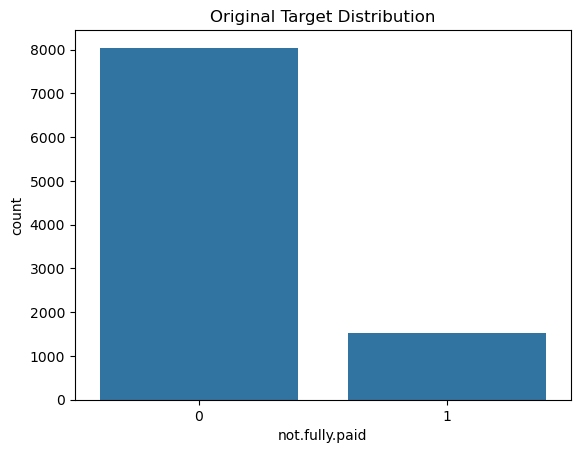

In [8]:
sns.countplot(x='not.fully.paid', data=df)
plt.title("Original Target Distribution")
plt.show()


In [9]:
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


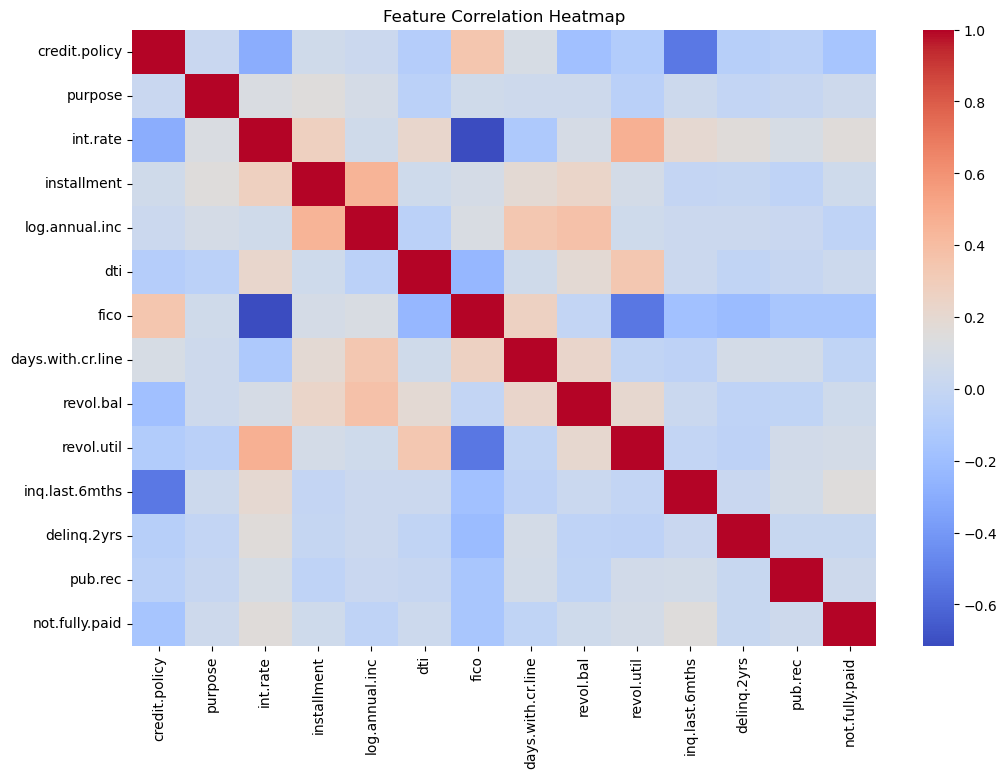

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [11]:
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
drop_cols


[]

In [12]:
df.drop(columns=drop_cols, inplace=True)


In [13]:
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [16]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


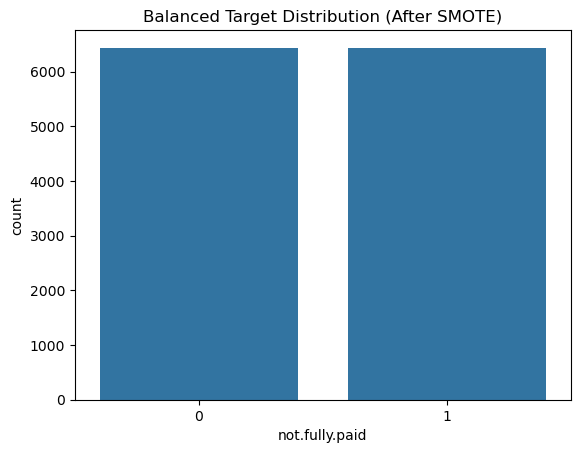

In [17]:
sns.countplot(x=y_train_res)
plt.title("Balanced Target Distribution (After SMOTE)")
plt.show()


In [18]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\rhtgh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6435 - loss: 0.6269 - val_accuracy: 0.4078 - val_loss: 0.7999
Epoch 2/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6564 - loss: 0.6112 - val_accuracy: 0.4272 - val_loss: 0.7887
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6616 - loss: 0.6056 - val_accuracy: 0.4571 - val_loss: 0.7662
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6679 - loss: 0.6028 - val_accuracy: 0.4179 - val_loss: 0.7707
Epoch 5/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6711 - loss: 0.5997 - val_accuracy: 0.4167 - val_loss: 0.8196
Epoch 6/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6751 - loss: 0.5956 - val_accuracy: 0.3592 - val_loss: 0.8485
Epoch 7/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6715 - loss: 0.5947 - val_accuracy: 0.3899 - val_loss: 0.8266
Epoch 8/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6797 - loss: 0.5899 - val_accuracy: 

In [20]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1308  301]
 [ 183  124]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1609
           1       0.29      0.40      0.34       307

    accuracy                           0.75      1916
   macro avg       0.58      0.61      0.59      1916
weighted avg       0.78      0.75      0.76      1916



In [21]:
sensitivity = recall_score(y_test, y_pred)
print("Sensitivity (Recall):", sensitivity)


Sensitivity (Recall): 0.40390879478827363


In [22]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.6740059478139051


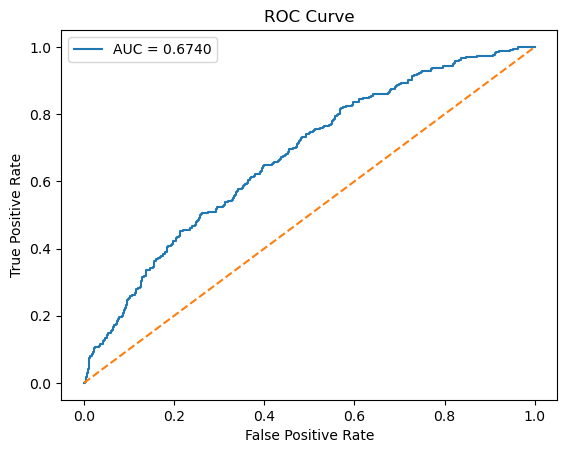

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


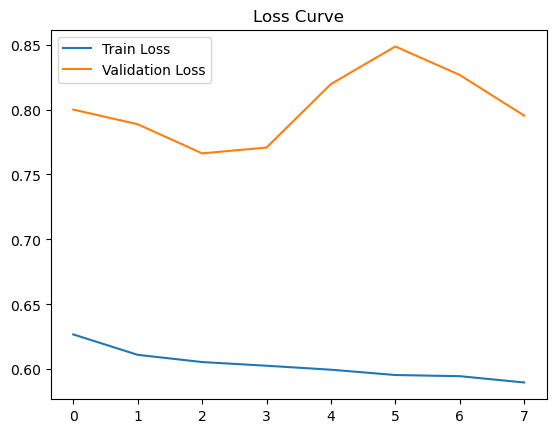

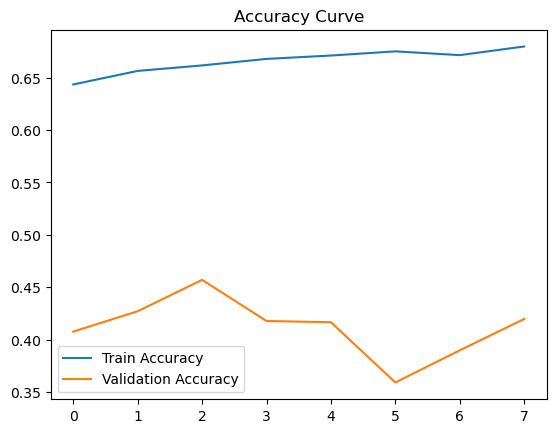

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()
